## Applying K-means Clustering to Determine the Granite Composition Percentage in Mineral Images

### import libraries

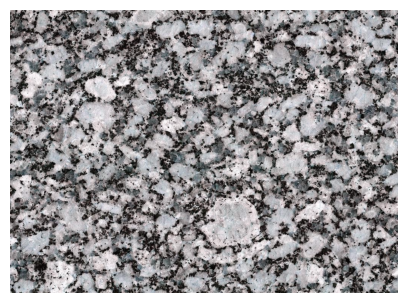

In [9]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
%matplotlib inline

# Loading the image using OpenCV
img = cv2.imread("Granite.jpeg", cv2.IMREAD_COLOR)
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(5, 5))
plt.imshow(img)  
plt.axis('off') 
plt.show()

### Conversion of 2d image into 1d vector

In [10]:
# mage (height, width, channels)
image_shape = img.shape
print("Original Image Shape:", image_shape)

#(rows represent pixels, columns represent R, G, B values)
rgb_2d = img.reshape((-1, 3))
print("Reshaped 2D Array Shape:", rgb_2d.shape)

Original Image Shape: (749, 1024, 3)
Reshaped 2D Array Shape: (766976, 3)


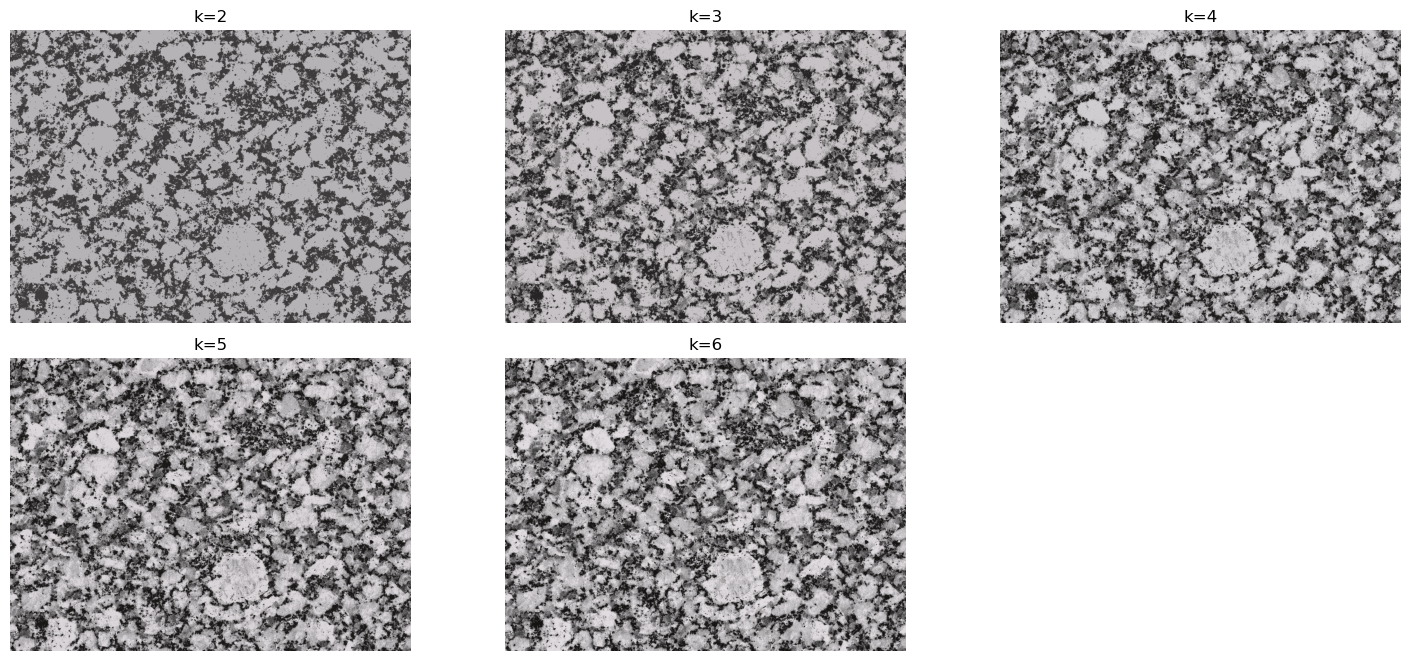

In [31]:
num_clusters_range = range(2, 7)

plt.figure(figsize=(15, 10))

for i, num_clusters in enumerate(num_clusters_range, 1):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init='auto')
    kmeans.fit(rgb_2d)
    labels = kmeans.predict(rgb_2d)
    centroids = kmeans.cluster_centers_
    center = np.uint8(centroids)

    # Reshaping the labels back to the shape of the original image
    segmented_data = center[labels.flatten()]
    seg_image = segmented_data.reshape(img.shape)

    plt.subplot(3, 3, i)
    plt.imshow(seg_image)
    plt.axis('off')
    plt.title('k=' + str(num_clusters))

plt.tight_layout()
plt.show()

### Visualization of Granite (Dark mineral) for k=8 

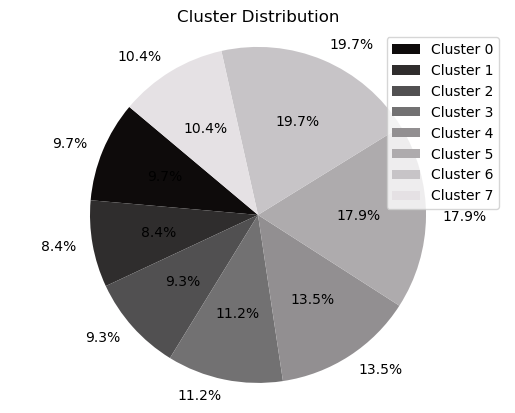

In [35]:
colors, counts = np.unique(seg_image.reshape(-1, 3), axis=0, return_counts=True)

# Calculate percentages for each cluster
total_pixels = np.sum(counts)
percentages = (counts / total_pixels) * 100
percentage_labels = [f"{p:.1f}%" for p in percentages]

plt.pie(counts, colors=colors / 255, labels=percentage_labels, autopct="%1.1f%%", startangle=140)

plt.title("Cluster Distribution")
plt.axis('equal') 

legend_labels = [f"Cluster {i}" for i in range(len(counts))]
plt.legend(legend_labels)

plt.show()


In [34]:
data = {'Color': [tuple(color) for color in colors], 'Count': counts}

r_values = colors[:, 0]
g_values = colors[:, 1]
b_values = colors[:, 2]

df = pd.DataFrame({
    'R': r_values,
    'G': g_values,
    'B': b_values,
    'Count': counts
})
df.head()

,R,G,B,Count
0,14,11,11,74535
1,47,45,45,64055
2,81,80,81,71040
3,114,113,114,85540
4,146,143,145,103864


### Calculate the pixel area covered by each cluster

In [36]:
total_pixels = np.sum(counts)

# Calculate the fraction of the image covered by each cluster
fraction_per_cluster = counts / total_pixels
print(fraction_per_cluster)

[0.09718036 0.0835163  0.0926235  0.11152891 0.13542014 0.17892476
 0.19687709 0.10392894]


In [37]:
#If the area is 2,00,000 the area covered by clusters is given by:

area = 200000
area_per_cluster = area* fraction_per_cluster
print(area_per_cluster)

[19436.07101135 16703.26059746 18524.69959947 22305.78271028
 27084.02870494 35784.95285381 39375.41722296 20785.78729973]


k-value 2
k-value 3
k-value 4
k-value 5
k-value 6
k-value 7
k-value 8
k-value 9
k-value 10
k-value 11
k-value 12
k-value 13
k-value 14
k-value 15
k-value 16
k-value 17
k-value 18
k-value 19


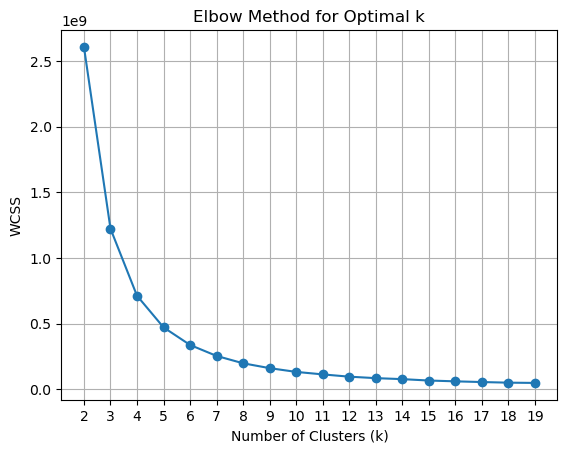

In [39]:
k_values = range(2, 20)

# Calculate WCSS for each k value
wcss = []
for k in k_values:
    print('k-value',k)
    kmeans = KMeans(n_clusters=k,n_init='auto')
    kmeans.fit(rgb_2d)
    wcss.append(kmeans.inertia_)

# Plot the elbow graph
plt.plot(k_values, wcss, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal k')
plt.xticks(k_values)
plt.grid(True)
plt.show()

### Using Elbow method, we can see there is sharp decrease from 2 to 6. And small decrease moving on.
#### so, choosing the value of k=7

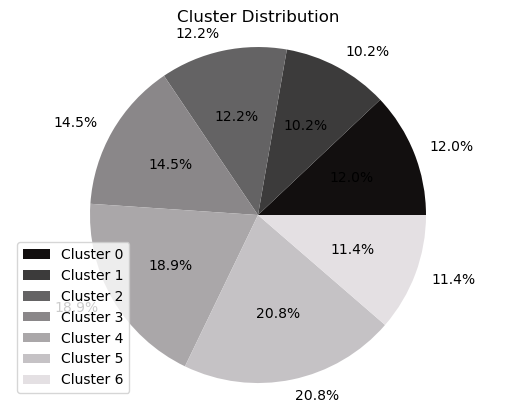

In [41]:
k=7

opt_kmeans = KMeans(n_clusters=7, random_state=42,n_init="auto")
opt_kmeans.fit(rgb_2d)
opt_labels = opt_kmeans.predict(rgb_2d)

opt_center = np.uint8(opt_kmeans.cluster_centers_)

opt_segmented_data = opt_center[opt_labels.flatten()]
opt_seg_image = opt_segmented_data.reshape(img.shape)

opt_colors, opt_counts = np.unique(opt_seg_image.reshape(-1, 3), axis=0, return_counts=True)

# Calculate percentages for each cluster
opt_total_pixels = np.sum(opt_counts)
opt_percentages = (opt_counts / opt_total_pixels) * 100

# Convert percentages to strings with one decimal point
opt_percentage_labels = [f"{p:.1f}%" for p in opt_percentages]

# Create the pie chart
plt.pie(opt_counts, colors=opt_colors / 255, labels=opt_percentage_labels, autopct="%1.1f%%")

plt.title("Cluster Distribution")
plt.axis('equal') 

# Add a legend with cluster labels (0, 1, 2)
opt_legend_labels = [f"Cluster {i}" for i in range(len(opt_counts))]
plt.legend(opt_legend_labels)

plt.show()


## The black mineral covers about 12% of the total area in the image

In [42]:

def silhoutte(img,k_values):
    silhouette_scores = []
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42,n_init='auto')
        cluster_labels = kmeans.fit_predict(img)

        silhouette_avg = silhouette_score(img, cluster_labels)
        silhouette_scores.append(silhouette_avg)

        sample_silhouette_values = silhouette_samples(img, cluster_labels)

        fig, ax1 = plt.subplots()
        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(img) + (k + 1) * 10])

        y_lower = 10

        for i in range(k):
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / k)
            ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            y_lower = y_upper + 10

        ax1.set_xlabel("Silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        plt.title(f"Silhouette plot for K = {k}")
        plt.show()

    # Plot the silhouette scores
    plt.plot(k_values, silhouette_scores, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Analysis for Optimal k')
    plt.xticks(k_values)
    plt.grid(True)
    plt.show()

In [43]:
rgb_2d.shape

(766976, 3)

In [64]:
print('Original Dimensions: ', rgb_2d.shape)

# Percentage by which the image will be resized
resize_percentage = -30

# Calculating the new dimensions after resizing
new_width = int(rgb_2d.shape[1] * (1 + resize_percentage / 100))
new_height = int(rgb_2d.shape[0] * (1 + resize_percentage / 100))

resized_image = cv2.resize(rgb_2d, (new_width, new_height))
print('Resized Dimensions: ', resized_image.shape)

Original Dimensions:  (766976, 3)
Resized Dimensions:  (536883, 2)


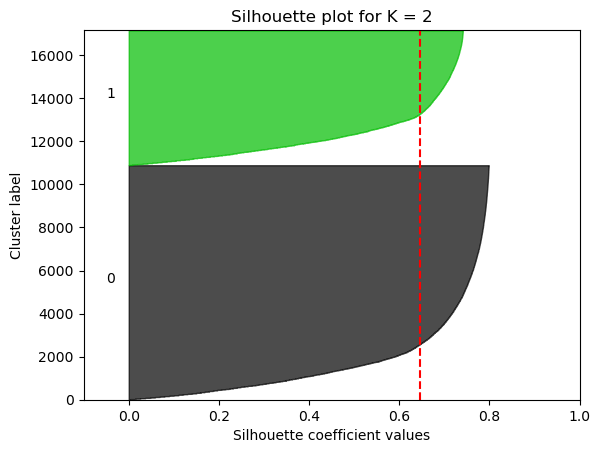

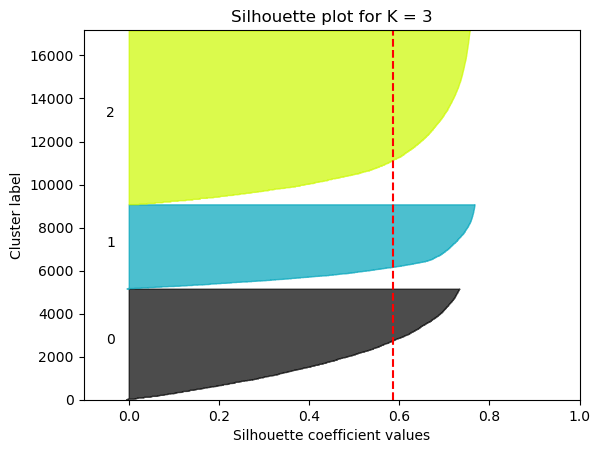

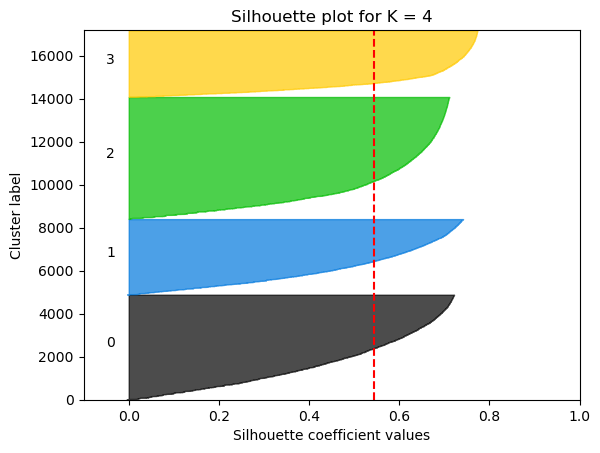

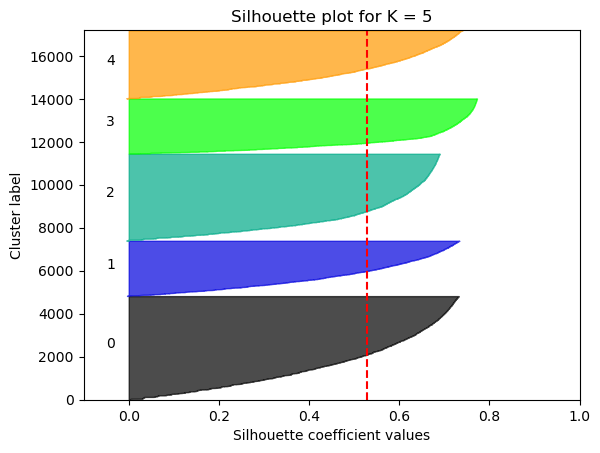

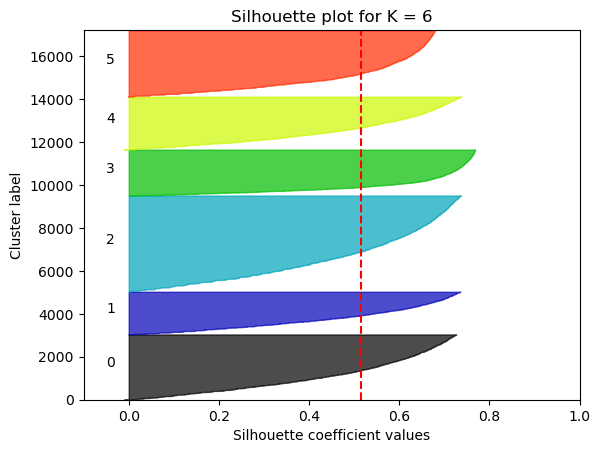

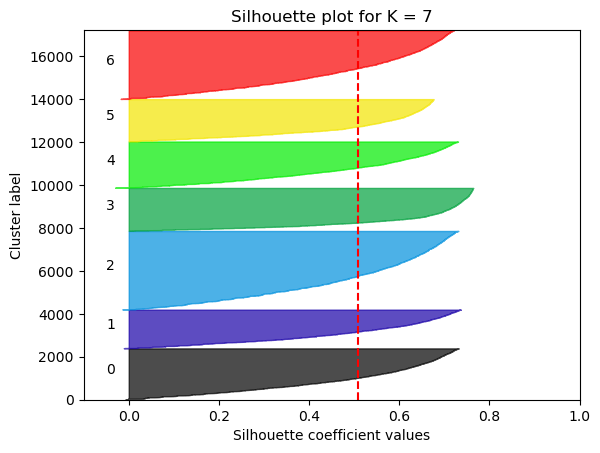

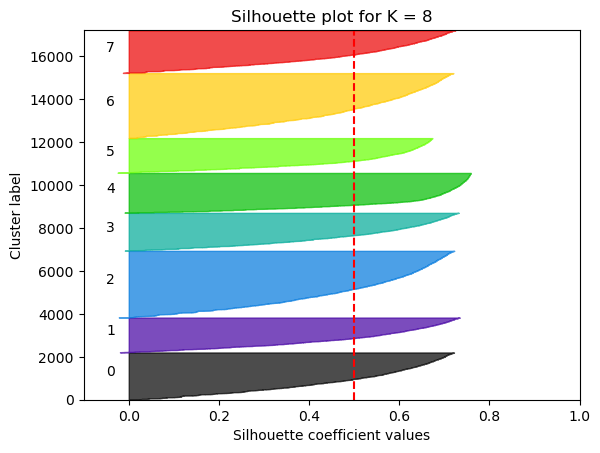

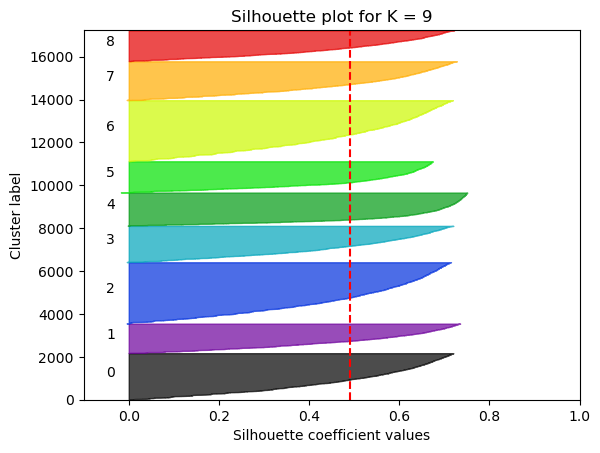

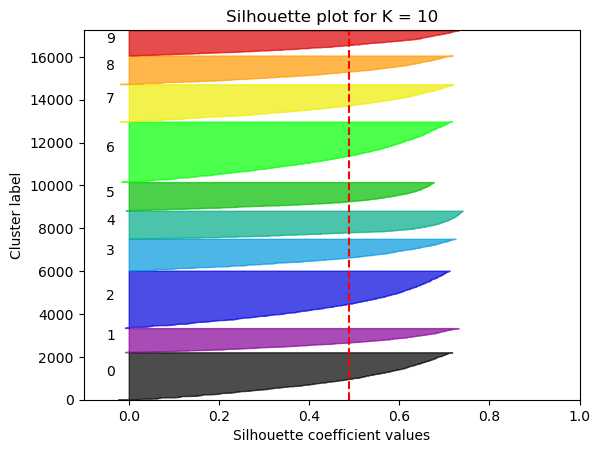

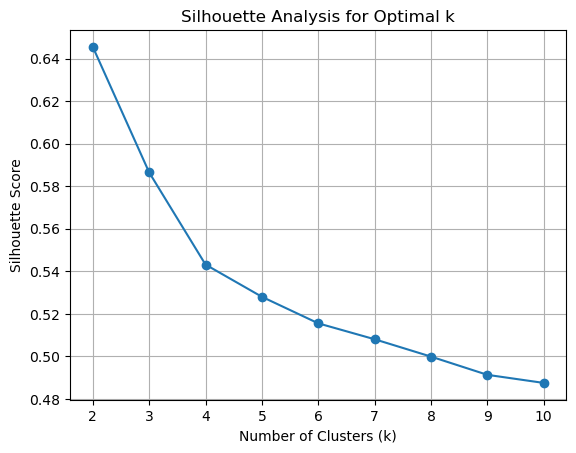

In [28]:
resized_2d = resized_image.reshape((-1,3))
silhoutte(resized_2d,range(2,11))